# RAG-pipeline

full flow from the BD perspective:
1. User Query → Sent to RAG Pipeline (via API Layer).
2. RAG Pipeline (in a Container):
   - Preprocess Query (tokenization, cleaning, etc.).
   - Embed Query → Convert to vector.
   - Retrieve Data from Qdrant Vector Database.
   - Rerank Documents for relevance.
   - Generate Response using LLM (query + context).
3. Response → Return to User (via API Layer).

##  Load API-key

In [2]:
from dotenv import load_dotenv
import os

load_dotenv()  # loads the variable from .env-file
api_key = os.getenv("MISTRAL_API_KEY")

## RAG - NOT finishes

In [70]:
# 1. template is from https://docs.mistral.ai/guides/rag/#rag-with-haystack
# 2. template is from https://docs.haystack.deepset.ai/docs/pipeline-templates

###############################################
# changes in 1. template were made with help of claude.ai
#  1. DynamicChatPromptBuilder replaced by ChatPromptBuilder
#  1.a. ChatPromptBuilder doesn't use runtime_variables or prompt_source parameters
#  1.b. Instead, it takes the messages directly as template
#  1.c. The template variables are passed directly to the run method
#  2.a. Changed the import from DynamicChatPromptBuilder to ChatPromptBuilder
#  2.b. Removed the runtime_variables parameter from the prompt builder initialization
#  2.c. Changed prompt_source to template in the pipeline run parameters
#  2.d. Added documents as a template variable in the run parameters
#  3. Ah, I see the issue. The ChatPromptBuilder doesn't have a documents input socket like DynamicChatPromptBuilder did. Instead, we need to pass the documents through the template_variables. Here's the corrected code:
#  3.a. Removed the connection between retriever and prompt_builder since ChatPromptBuilder doesn't have a documents input
#  3.b. Added the documents directly in the template_variables
#  3.c. Added retriever query parameter in the pipeline run
#  4. Ah, I see the issue. For the InMemoryEmbeddingRetriever, we need to provide the query_embedding, not the raw query. Let me correct the code:
#  4.a. Removed the direct "retriever" input from the pipeline run
#  4.b. In the template_variables, we now get the documents by:
#  4.b.a. First getting the embedding for the question using text_embedder
#  4.b.b. Then using that embedding to retrieve documents from the retriever
#  4.b.c. Passing those retrieved documents to the template_variables
#  5. Ah, I see. There's been an API change in Haystack where we need to use .text instead of .content to access the message content. Here's the corrected code:
###############################################


from haystack import Pipeline
from haystack.document_stores.in_memory import InMemoryDocumentStore
from haystack.dataclasses import ChatMessage
from haystack.utils.auth import Secret

from haystack.components.builders import ChatPromptBuilder
from haystack.components.converters import TextFileToDocument
from haystack.components.preprocessors import DocumentSplitter
from haystack.components.retrievers.in_memory import InMemoryEmbeddingRetriever
from haystack.components.writers import DocumentWriter
from haystack_integrations.components.embedders.mistral import MistralDocumentEmbedder, MistralTextEmbedder
from haystack_integrations.components.generators.mistral import MistralChatGenerator


###############################################
# Data
import requests
response = requests.get('https://raw.githubusercontent.com/run-llama/llama_index/main/docs/docs/examples/data/paul_graham/paul_graham_essay.txt')
text = response.text
f = open('essay.txt', 'w')
f.write(text)
f.close()
###############################################


document_store = InMemoryDocumentStore()
docs = TextFileToDocument().run(sources=["essay.txt"])
split_docs = DocumentSplitter(split_by="passage", split_length=2).run(documents=docs["documents"])
embeddings = MistralDocumentEmbedder(api_key=Secret.from_token(api_key)).run(documents=split_docs["documents"])
DocumentWriter(document_store=document_store).run(documents=embeddings["documents"])

text_embedder = MistralTextEmbedder(api_key=Secret.from_token(api_key))
retriever = InMemoryEmbeddingRetriever(document_store=document_store)
prompt_builder = ChatPromptBuilder()
llm = MistralChatGenerator(api_key=Secret.from_token(api_key), 
                          model='mistral-large-latest')

chat_template = """Answer the following question based on the contents of the documents. Provide your response in JSON format\n
                Question: {{query}}\n
                Documents: 
                {% for document in documents %}
                    {{document.content}}
                {% endfor%}
                """
messages = [ChatMessage.from_user(chat_template)]

rag_pipeline = Pipeline()
rag_pipeline.add_component("text_embedder", text_embedder)
rag_pipeline.add_component("retriever", retriever)
rag_pipeline.add_component("prompt_builder", prompt_builder)
rag_pipeline.add_component("llm", llm)
rag_pipeline.connect("text_embedder.embedding", "retriever.query_embedding")
rag_pipeline.connect("prompt_builder.prompt", "llm.messages")

question = "What were the two main things the author worked on before college?"
result = rag_pipeline.run(
    {
        "text_embedder": {"text": question},
        "prompt_builder": {
            "template": messages,
            "template_variables": {
                "query": question,
                "documents": retriever.run(query_embedding=text_embedder.run(text=question)["embedding"])["documents"]
            }
        },
        "llm": {"generation_kwargs": {
            "max_tokens": 225,
            "response_format": {"type": "json_object"}
            }},
    }
)
print(result["llm"]["replies"][0].text)  # Changed from .content to .text

Calculating embeddings: 3it [00:03,  1.07s/it]


{
 "main_things_worked_on": [
   "writing",
   "programming"
 ]
}


## Visualizing Pipelines

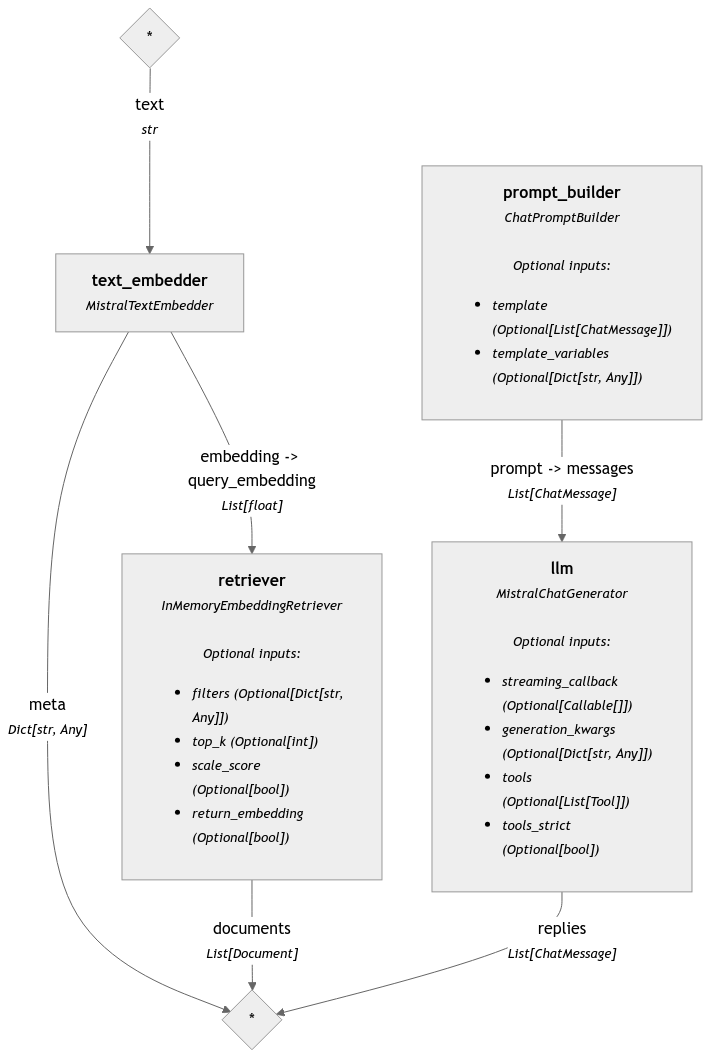

In [69]:
rag_pipeline.show()
